# TorchSpatial Tutorial


## Overview
This tutorial notebook offers a comprehensive, hands-on introduction to the **TorchSpatial** framework. It guides users through the process of spatial representation learning using various location encoders. The tutorial starts with setting up the environment and loading necessary datasets, followed by demonstrating how to initialize a location encoder.

### Key Features:
1. **TorchSpatial Model Framework**:  
   We provide a framework that supports the development of location encoders. Currently, **TorchSpatial** consolidates 15 widely used location encoders and essential model-building blocks, ensuring scalability and reproducibility for future location encoder development.

2. **LocBench Benchmark**:  
   We offer the **LocBench** benchmark, which contains 7 geo-aware image classification datasets and 10 image regression datasets. These datasets are used to systematically evaluate the performance of any location encoder across varied task setups, geographic distributions, and dataset sizes.

3. **Comprehensive Evaluation Metrics**:  
   We provide a thorough set of evaluation metrics to assess the overall model performance of location encoders, as well as their geographic bias. This includes a novel **Geo-Bias Score**, which, to the best of our knowledge, is the first universally applicable geographic bias evaluation framework designed to assess AI models, such as large language models.

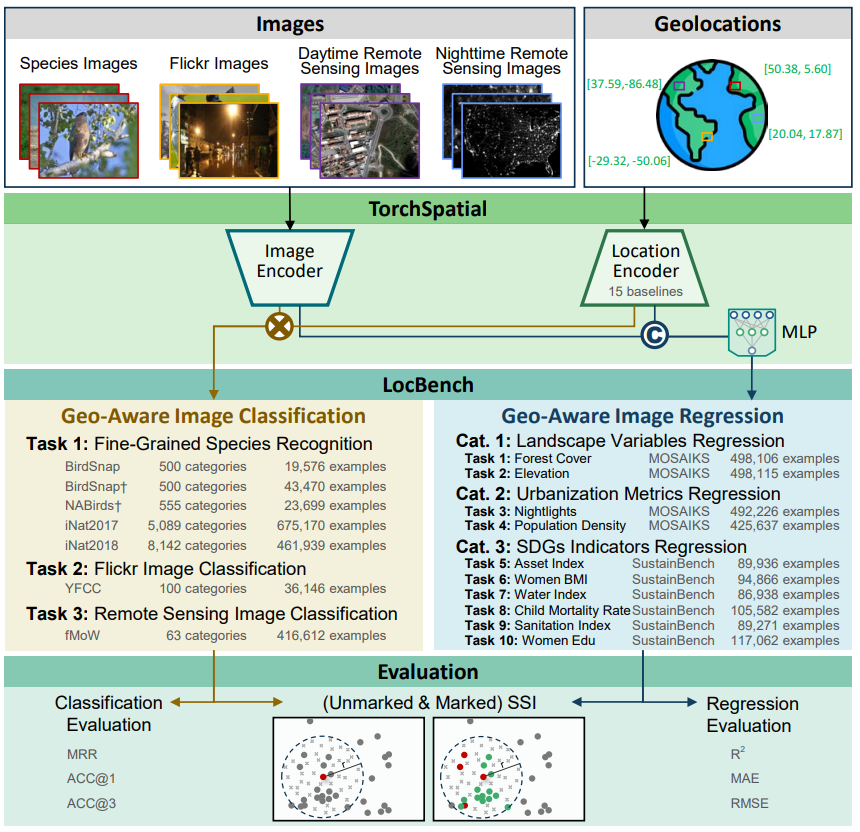

## Table of Contents
- [I. Environment Settings](#i-environment-settings)
- [II. Data Download](#ii-data-download)
- [III. Initializing a Location Encoder](#iii-initializing-a-location-encoder)
- [IV. Experiments on Benchmark Datasets](#iv-experiments-on-benchmark-datasets)
- [V. Model Evaluation](#v-model-evaluation)

## I. Environment Settings

To set up the environment for the TorchSpatial project, follow these steps:

1. **Install Conda (if not already installed)**  
   Ensure you have [Anaconda](https://www.anaconda.com/products/distribution) or [Miniconda](https://docs.conda.io/en/latest/miniconda.html) installed on your system. You can download the installer from the respective links.

2. **Create the Conda Environment**  
   Open your terminal (or Anaconda Prompt on Windows) and navigate to the directory containing the `environment.yml` file. Use the following command to create the environment:
   ```bash
   conda env create -f environment.yml 
   ```
   Alternatively, you can create the environment directly using the `requirements.txt` file:
   ```bash
   pip install -r https://github.com/seai-lab/TorchSpatial/blob/main/main/requirements.txt


## II. Data Download

The datasets can be downloaded from the following DOI link: [Download Data](https://figshare.com/articles/dataset/LocBench/26026798).

1. **Download the dataset from the specified URL**  
   For example, to download the Birdsnap dataset, use the following command in the terminal:
   ```bash
   wget https://figshare.com/ndownloader/files/47020978
2. **Extract the contents of the tar file and move the files to the desired folder if necessary**  
   ```bash
   tar -xvf 47020978
3. **Update the path for dataset**  
   Please navigate to `main/paths.py` and ensure that the dataset path matches the corresponding entry in `main/paths.py`.



## III. Initializing a Location Encoder

In [1]:
import sys
import os
base_path = os.path.join(os.getcwd(), 'main')
sys.path.append(base_path)

import torch
import numpy as np

from SpatialRelationEncoder import *
from module import *
from data_utils import *
from utils import *

TThe location encoder type in TorchSpatial can be one of the following:
`Space2Vec-grid`, `Space2Vec-theory`, `xyz`, `NeRF`, `Sphere2Vec-sphereC`, `Sphere2Vec-sphereC+`, `Sphere2Vec-sphereM`, `Sphere2Vec-sphereM+`, `Sphere2Vec-dfs`, `rbf`, `rff`, `wrap`, `wrap_ffn`, or `tile_ffn`.

**2D Location Encoders in TorchSpatial**

TorchSpatial implements the following 7 location encoders designed for projected 2D space:
1. **tile**  
   A naive encoder that divides the space into fixed partitions and assigns each location a representation based on its partition.
2. **wrap**  
   A sinusoidal encoder that transforms each spatial dimension into a pair of wrapped coordinates and feeds them into a neural network with residual layers (`NN^wrap()`).
3. **wrap + ffn**  
   A variant of `wrap` that replaces `NN^wrap()` with a feedforward network (`NN^ffn()`).
4. **rbf**  
   A kernel-based encoder that selects anchor points from the training data and computes Gaussian similarity scores for each input location. The resulting feature vector is passed into `NN^ffn()`.
5. **rff** (Random Fourier Features)  
   Projects each location into a high-dimensional space using random Fourier transformations. The result is then passed into `NN^ffn()` for the final embedding.
6. **Space2Vec-grid**  
   A multi-scale encoder that applies a deterministic Fourier mapping on 2D coordinates, followed by a neural network (`NN^ffn()`).
7. **Space2Vec-theory**  
   Similar to `Space2Vec-grid`, but uses a theoretically grounded variant of the Fourier mapping for encoding spatial structure.

**3D Location Encoders in TorchSpatial**

TorchSpatial also supports 8 encoders that operate on 3D space:
1. **xyz**  
   Converts lat-lon coordinates into 3D Cartesian coordinates, then uses a feedforward network (`NN^ffn()`) for encoding.
2. **NeRF**  
   A multiscale encoder that extends `xyz` using Neural Radiance Fields (NeRF) to model complex spatial patterns.
3. **Sphere2Vec family**  
   A group of multi-scale encoders specifically designed for spherical surfaces:
   - `Sphere2Vec-sphereC`
   - `Sphere2Vec-sphereC+`
   - `Sphere2Vec-sphereM`
   - `Sphere2Vec-sphereM+`
   - `Sphere2Vec-dfs`  
   These encoders aim to preserve spherical surface distances.
4. **Siren (SH)**  
   A spherical encoder that uses spherical harmonic functions as position encodings, paired with a sinusoidal neural network (SirenNet) for representation learning.

In [2]:
'''
Example of initializing a 'Space2Vec-grid' location encoder. 
'''

# Specify the params for the location encoder, current spa_embed_dim is 128
params = {
    # The type of location encoder you will use, FIXED
    'spa_enc_type': 'Space2Vec-grid', # type of locaiton encoder
    'spa_embed_dim': 128,  # The dimension of the location embedding,TUNE
    'extent': (0, 200, 0, 200),  # Extent of the coords, FIXED
    'freq': 16,  # The number of scales, TUNE (See Equation(3) in (Mai, 2020))
    # Lambda_max, maximum scale, FIXED (See Equation(4) in (Mai, 2020))
    'max_radius': 1,
    # Lambda_min, minimum scale, TUNE (See Equation(4) in (Mai, 2020))
    'min_radius': 0.0001,
    'spa_f_act': "leakyrelu",  # Activation function, FIXED
    'freq_init': 'geometric',  # The method to make the Fourier frequency, FIXED
    'num_hidden_layer': 1,  # The number of hidden layer, TUNE
    'dropout': 0.5,  # Dropout rate, TUNE
    'hidden_dim': 512,  # Hidden embedding dimension, TUNE
    'use_layn': True,  # whether to you layer normalization, FIXED
    'skip_connection': True,  # Whether to use skip connection, FIXED
    'spa_enc_use_postmat': True,  # FIXED
    'device': 'cpu'  # The device, ‘cpu’ or ‘cuda:0’, etc
}

loc_enc = get_spa_encoder(
    train_locs=[],
    params=params,
    spa_enc_type=params['spa_enc_type'],
    spa_embed_dim=params['spa_embed_dim'],
    extent=params['extent'],
    coord_dim=2,
    frequency_num=params['freq'],
    max_radius=params['max_radius'],
    min_radius=params['min_radius'],
    f_act=params['spa_f_act'],
    freq_init=params['freq_init'],
    use_postmat=params['spa_enc_use_postmat'],
    device=params['device']).to(params['device'])

In [3]:
# synthetic coords data
batch_size, coord_dim = 1024, 2
coords = np.random.randint(1, 201, size=(batch_size, coord_dim))

# coords: shape [batch_size, 2]
coords

array([[ 72,   5],
       [ 50,  99],
       [ 88, 150],
       ...,
       [ 76,  56],
       [137,  42],
       [  2,  44]])

In [4]:
coords = np.array(coords)
coords = np.expand_dims(coords, axis=1)
loc_embeds = torch.squeeze(loc_enc(coords))

# loc_embed: shape [batch_size, spa_embed_dim]
loc_embeds

tensor([[-0.0000,  1.6803, -0.0000,  ...,  0.0000, -0.0000,  2.8341],
        [-0.5246, -0.0820,  2.5519,  ..., -0.5428,  2.2160, -0.0000],
        [-0.0000, -0.4490,  0.0000,  ...,  0.0000, -0.3583, -0.0000],
        ...,
        [ 0.0000, -0.0000,  3.2221,  ...,  2.2676, -0.1668,  4.5811],
        [-0.3717, -0.0000,  1.3331,  ...,  2.6777,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.9117]],
       grad_fn=<SqueezeBackward0>)

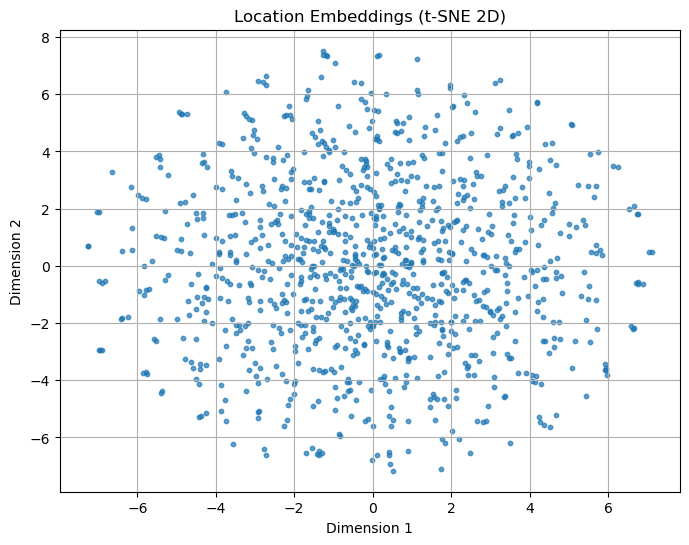

In [5]:
'''
This Python script visualizes location embeddings using t-SNE (t-Distributed Stochastic Neighbor Embedding), a nonlinear dimensionality reduction technique commonly used for high-dimensional data visualization.
'''

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Step 1: Convert tensor to numpy array
embeds_np = loc_embeds.detach().cpu().numpy()

# Step 2: Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeds_2d = tsne.fit_transform(embeds_np)

# Step 3: Visualization
plt.figure(figsize=(8, 6))
plt.scatter(embeds_2d[:, 0], embeds_2d[:, 1], s=10, alpha=0.7)
plt.title("Location Embeddings (t-SNE 2D)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


## IV. Experiments on Benchmark Datasets 

### 1. Evaluating Location Encoder on LocBench
We can evaluate the performance of the location encoder on the **LocBench** datasets, which include **17 geo-aware image classification and regression tasks**, as illustrated in the figure below:

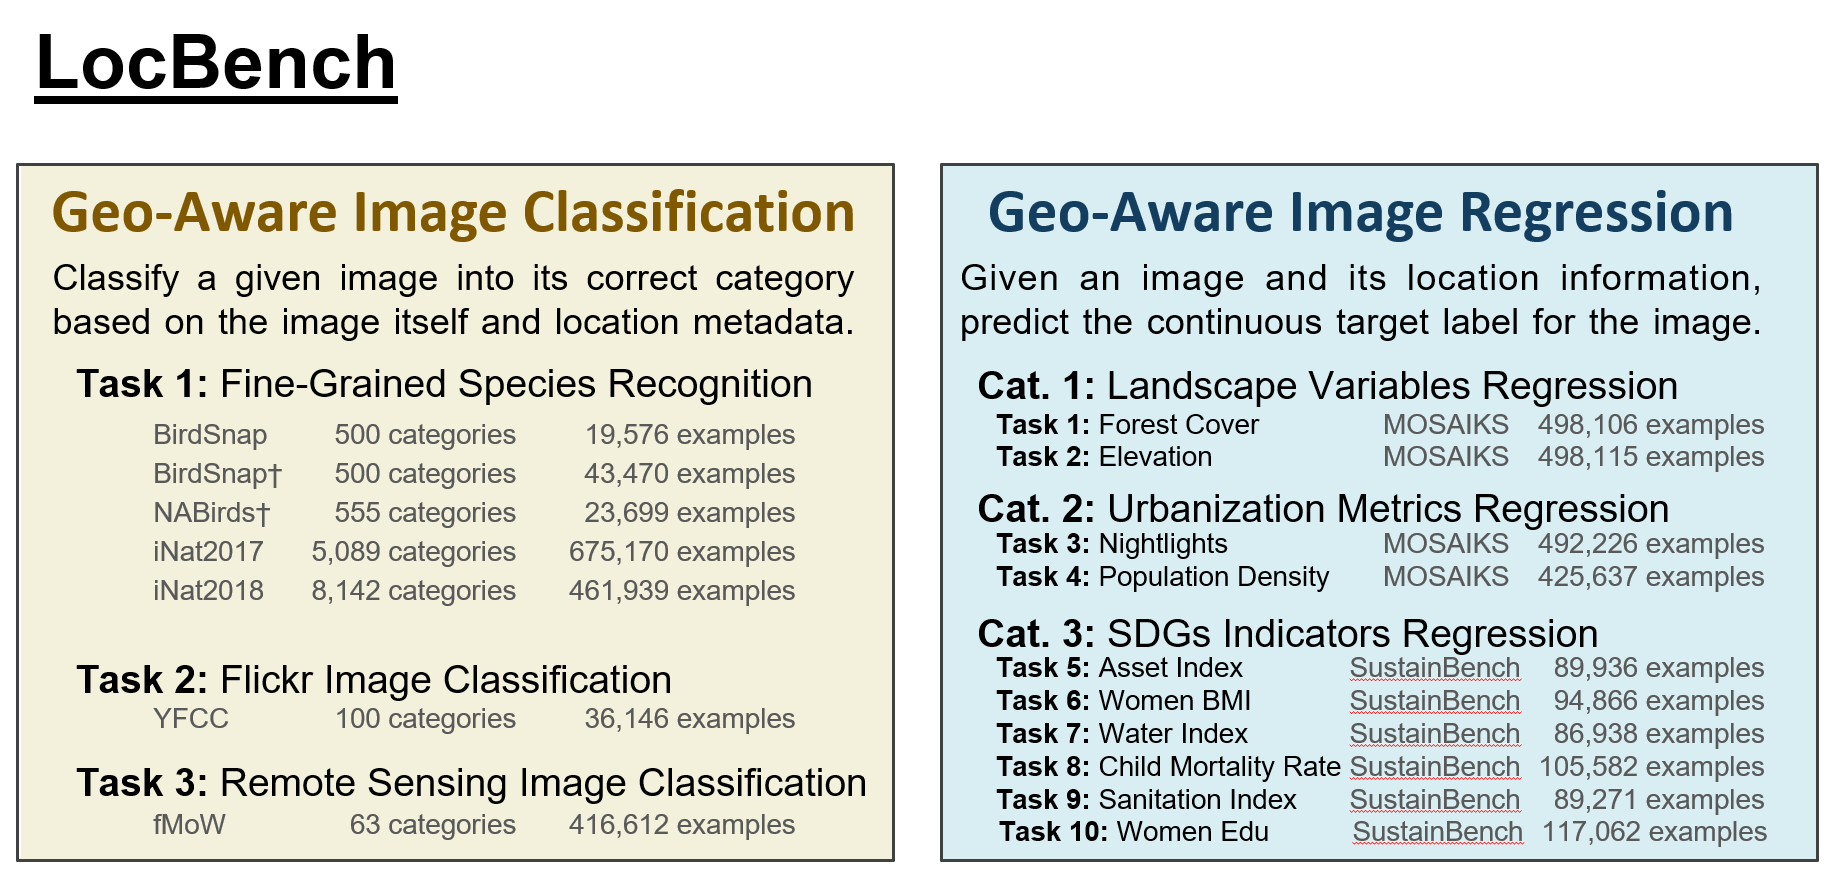

The **main script** for model evaluation and experiments is located at: `TorchSpatial/main/main.py`. Below are the **key command-line arguments** with their descriptions and default values.

##### 🛠️ General Options
```python
    parser.add_argument("--save_results", type=str, default="T", 
        help="Save the results (lon, lat, rr, acc1, acc3) to a CSV file for final evaluation."
    )
    parser.add_argument("--device", type=str, 
        default=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        help="Device to use: 'cuda' for GPU or 'cpu' for CPU."
    )
    parser.add_argument("--model_dir", type=str, default="../models/",
        help="Directory where models are stored."
    )
    parser.add_argument("--num_epochs", type=int, default=20,
        help="Number of training epochs."
    )
    parser.add_argument("--load_super_model", type=str, default="F", 
        help="Load a pretrained supervised model (T/F)."
    )
```
#### 📂 Dataset Options
```python
    parser.add_argument("--dataset", type=str, default="birdsnap", 
        choices=[
            "inat_2021", "inat_2018", "inat_2017", "birdsnap", "nabirds", 
            "yfcc", "fmow", "sustainbench_asset_index", 
            "sustainbench_under5_mort", "sustainbench_water_index", 
            "sustainbench_women_bmi", "sustainbench_women_edu", 
            "sustainbench_sanitation_index", "mosaiks_population", 
            "mosaiks_elevation", "mosaiks_forest_cover", 
            "mosaiks_nightlights"
        ],
        help="Dataset to use for the experiment."
    )
    parser.add_argument("--train_sample_ratio", type=float, default=0.01,
        help="Training dataset sample ratio for supervised learning."
    )
    parser.add_argument("--train_sample_method", type=str, default="random-fix",
        help="""Training dataset sampling method:
        - 'stratified-fix': Stratified sampling with fixed indices.
        - 'stratified-random': Stratified sampling with random indices.
        - 'random-fix': Random sampling with fixed indices.
        - 'random-random': Random sampling with random indices.
        - 'ssi-sample': Sample based on spatial self-information.
        """
    )
```
#### ⚙️ Training Hyperparameters
```python
    parser.add_argument("--lr", type=float, default=0.001, 
        help="Learning rate."
    )
    parser.add_argument("--lr_decay", type=float, default=0.98, 
        help="Learning rate decay factor."
    )
    parser.add_argument("--weight_decay", type=float, default=0.0, 
        help="Weight decay (L2 regularization)."
    )
    parser.add_argument("--dropout", type=float, default=0.5, 
        help="Dropout rate used in the feedforward neural network."
    )
    parser.add_argument("--batch_size", type=int, default=1024, 
        help="Batch size for training."
    )

```
#### 🔍 Logging and Evaluation
```python
    parser.add_argument("--log_frequency", type=int, default=50, 
        help="Frequency of logging (in batches)."
    )
    parser.add_argument("--max_num_exs_per_class", type=int, default=100, 
        help="Maximum number of examples per class."
    )
    parser.add_argument("--balanced_train_loader", type=str, default="T", 
        help="Use a balanced train loader (T/F)."
    )
    parser.add_argument("--eval_frequency", type=int, default=100, 
        help="Frequency of model evaluation (in batches)."
    )
    parser.add_argument("--unsuper_save_frequency", type=int, default=5, 
        help="Frequency of saving unsupervised models (in epochs)."
    )
    parser.add_argument("--do_epoch_save", type=str, default="F", 
        help="Save the model at each epoch (T/F)."
    )
```

To run the model, please navigate to the `TorchSpatial/main/` folder in the terminal and execute the command, for example:

```bash
python3 main.py \
    --save_results T \
    --load_super_model F \
    --spa_enc_type Sphere2Vec-sphereC \
    --meta_type ebird_meta \
    --dataset birdsnap \
    --eval_split test \
    --frequency_num 64 \
    --max_radius 1 \
    --min_radius 0.001 \
    --num_hidden_layer 1 \
    --hidden_dim 512 \
    --spa_f_act relu \
    --unsuper_lr 0.1 \
    --lr 0.001 \
    --model_dir ../models/sphere2vec_sphereC/ \
    --num_epochs 100 \
    --train_sample_ratio 1.0 \
    --device cpu


### 2. Model Hyperparameter Tuning

To tune the model hyperparameters, sample bash files are provided in the `TorchSpatial/main/run_sh` directory.


### 3. Model Fine Tuning

We have also provided several pre-trained models in the `TorchSpatial/pre_trained_models` directory. If you would like to fine-tune one of these models, please set the corresponding model path and load the model. Example Bash files can be found in `TorchSpatial/main/eva_sh`. For example:

```bash
python3 main.py \
    --save_results T \
    --load_super_model T \
    --spa_enc_type Sphere2Vec-sphereC \
    --meta_type ebird_meta \
    --dataset birdsnap \
    --eval_split test \
    --frequency_num 64 \
    --max_radius 1 \
    --min_radius 0.001 \
    --num_hidden_layer 1 \
    --hidden_dim 512 \
    --spa_f_act relu \
    --unsuper_lr 0.1 \
    --lr 0.001 \
    --model_dir ../models/sphere2vec_sphereC/ \
    --train_sample_ratio 1.0 \
    --device cpu

In [6]:
'''
Case Codes:
An example of training the "Sphere2Vec-sphereC" location encoder on the Birdsnap dataset, which included over 42,000 training samples and 2,217 test samples, all enriched with image and metadata. Training proceeded over 20 epochs using the Sphere2Vec-sphereC model architecture, with a steady reduction in both training and test loss, indicating consistent learning and convergence. Final test performance without any prior enhancements (image-only model) yielded a Top-1 accuracy of 70.07%, with accuracy increasing to 92.88% at Top-10, reflecting the model's strong classification ability when given more candidate predictions. After integrating the Sphere2Vec-sphereC location encoder, performance significantly improved to 79.49% Top-1 accuracy and 96.15% Top-10 accuracy, underscoring the value of geospatial contextualization in fine-grained bird classification. However, when evaluating the location encoder (LocEnc) alone for predicting the correct class solely based on spatial input, the model achieved a modest 5.37% Top-1 accuracy, improving to 28.87% at Top-10. These results illustrate that while location encodings alone may not be sufficient for precise classification, their integration into a multimodal framework like Sphere2Vec-sphereC meaningfully enhances overall performance.
'''

import os
os.chdir("main")  # move into the 'main' folder

!python3 main.py \
    --save_results T \
    --load_super_model F \
    --spa_enc_type Sphere2Vec-sphereC \
    --meta_type ebird_meta \
    --dataset birdsnap \
    --eval_split test \
    --frequency_num 64 \
    --max_radius 1 \
    --min_radius 0.001 \
    --num_hidden_layer 1 \
    --hidden_dim 512 \
    --spa_f_act relu \
    --unsuper_lr 0.1 \
    --lr 0.001 \
    --model_dir ../models/sphere2vec_sphereC/ \
    --train_sample_ratio 1.0 \
    --device cpu

Loading birdsnap_with_loc_2019.json - train
   using meta data: ebird_meta
	 46386 total entries
	 43426 entries with images
	 42490 entries with meta data
Loading birdsnap_with_loc_2019.json - test
   using meta data: ebird_meta
	 2443 total entries
	 2262 entries with images
	 2217 entries with meta data
Pre-load dataset for final evaluation
Loading birdsnap_with_loc_2019.json - train
   using meta data: ebird_meta
	 46386 total entries
	 43426 entries with images
	 42490 entries with meta data
Loading birdsnap_with_loc_2019.json - test
   using meta data: ebird_meta
	 2443 total entries
	 2262 entries with images
	 2217 entries with meta data
	 keeping entries even without metadata
2025-04-16 00:02:27,544 - INFO - 
num_classes	500
2025-04-16 00:02:27,545 - INFO - num train    	42490
2025-04-16 00:02:27,545 - INFO - num val      	2217
2025-04-16 00:02:27,545 - INFO - train loss   	full_loss
2025-04-16 00:02:27,545 - INFO - model name   	../models/sphere2vec_sphereC/model_birdsnap_ebi

2025-04-16 00:02:31,803 - INFO - [41984/42490]	Loss  : 1.2493
2025-04-16 00:02:31,851 - INFO - Test loss   : 0.5211
2025-04-16 00:02:31,851 - INFO - 
Epoch	2
2025-04-16 00:02:33,551 - INFO - [41984/42490]	Loss  : 1.0412
2025-04-16 00:02:33,598 - INFO - Test loss   : 0.3899
2025-04-16 00:02:33,598 - INFO - 
Epoch	3
2025-04-16 00:02:35,222 - INFO - [41984/42490]	Loss  : 0.9547
2025-04-16 00:02:35,270 - INFO - Test loss   : 0.3545
2025-04-16 00:02:35,270 - INFO - 
Epoch	4
2025-04-16 00:02:36,973 - INFO - [41984/42490]	Loss  : 0.9024
2025-04-16 00:02:37,021 - INFO - Test loss   : 0.3396
2025-04-16 00:02:37,021 - INFO - 
Epoch	5
2025-04-16 00:02:38,651 - INFO - [41984/42490]	Loss  : 0.8718
2025-04-16 00:02:38,699 - INFO - Test loss   : 0.3276
2025-04-16 00:02:38,699 - INFO - 
Epoch	6
2025-04-16 00:02:40,419 - INFO - [41984/42490]	Loss  : 0.8472
2025-04-16 00:02:40,467 - INFO - Test loss   : 0.3284
2025-04-16 00:02:40,468 - INFO - 
Epoch	7
2025-04-16 00:02:42,194 - INFO - [41984/42490]	Loss 

### 4. Experiment Outputs

#### a. 🗒️ Log File  
- **Description**: A log file recording the training progress and final results.  
- **Example Path**:  
  `TorchSpatial/pre_trained_models/sphere2vec_sphereC/model_birdsnap_ebird_meta_Sphere2Vec-sphereC_inception_v3_0.0010_64_0.0010000_1_512.log`

  
#### b. 💾 Model Checkpoint  
- **Description**: A corresponding saved model checkpoint with the same name as the log file but with a `.pth.tar` extension.  
- **Example Path**:  
  `TorchSpatial/pre_trained_models/sphere2vec_sphereC/model_birdsnap_ebird_meta_Sphere2Vec-sphereC_inception_v3_0.0010_64_0.0010000_1_512.pth.tar`

#### c. 📊 Evaluation Table
- **Description** if `--save_results` is set to `T`, an evaluated table will be generated and saved.
- **Example Path**  
  `TorchSpatial/eval_results/classification/eval_birdsnap_ebird_meta_test_Sphere2Vec-sphereC.csv`
- **Table Contents**  
  - Each row represents a data point.  
  - Columns include the location and predicted performance metrics.
- **Example Columns**  
  - Classification Tasks:  
    - `lon`, `lat`, `true_class_prob`, `reciprocal_rank`, `hit@1`, `hit@3`  
  - Regression Tasks:  
    - `lon`, `lat`, `predictions`, `labels`, `relative_error`

## V. Model Evaluation

We can then do the model evaluation based on the model result tables. For geo-aware image regression tasks, we can calculate the R2, MAE, MSE scores; while for geo-aware image classification tasks, we can calculate the MRR, ACC@1, and ACC@3 scores. And for all models performances on all datsets, we can always calculate the geo-bias scores.

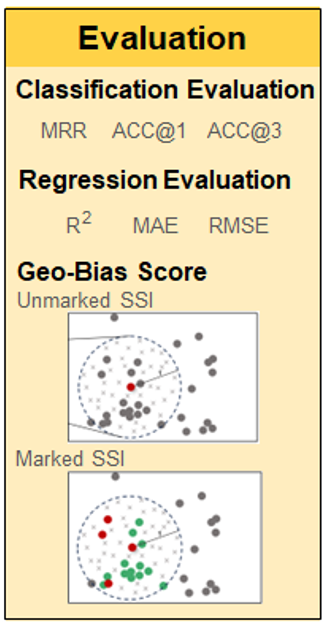

The example result table contains the evaluation results for an image classification task on the **iNat_2018** dataset. The objective is to classify the species present in a given image. Each image is also accompanied by geographic metadata (longitude and latitude). Below are the descriptions of the columns:

- **lon**: Longitude of the image location.
- **lat**: Latitude of the image location.
- **true_class_prob**: The predicted probability assigned to the true (ground truth) class by the model.
- **reciprocal_rank**: The reciprocal of the rank at which the correct class appears in the model's prediction list. A higher value indicates a better prediction.
- **hit@1**: A binary indicator (1 or 0) showing whether the top-1 predicted class matches the true class.
- **hit@3**: A binary indicator (1 or 0) showing whether the true class is among the top-3 predicted classes.

The **lon** and **lat** values represent the geographic coordinates of where the image was taken, which can be leveraged by location-aware models for improved classification accuracy.

In [7]:
import pandas as pd

df = pd.read_csv("../eval_results/eval_inat_2018__val_Sphere2Vec-sphereC+.csv")
df.head()

,Unnamed: 0,lon,lat,true_class_prob,reciprocal_rank,hit@1,hit@3
0,0,-82.276573,29.686216,0.885263,1.000000,1.0,1.0
1,1,-95.419724,29.042500,0.793877,1.000000,1.0,1.0
2,2,-101.824638,33.609531,0.969570,1.000000,1.0,1.0
3,3,-106.443001,23.299000,0.615989,1.000000,1.0,1.0
4,4,-122.503830,37.714001,0.000245,0.028571,0.0,0.0


### Geo-Bias Score
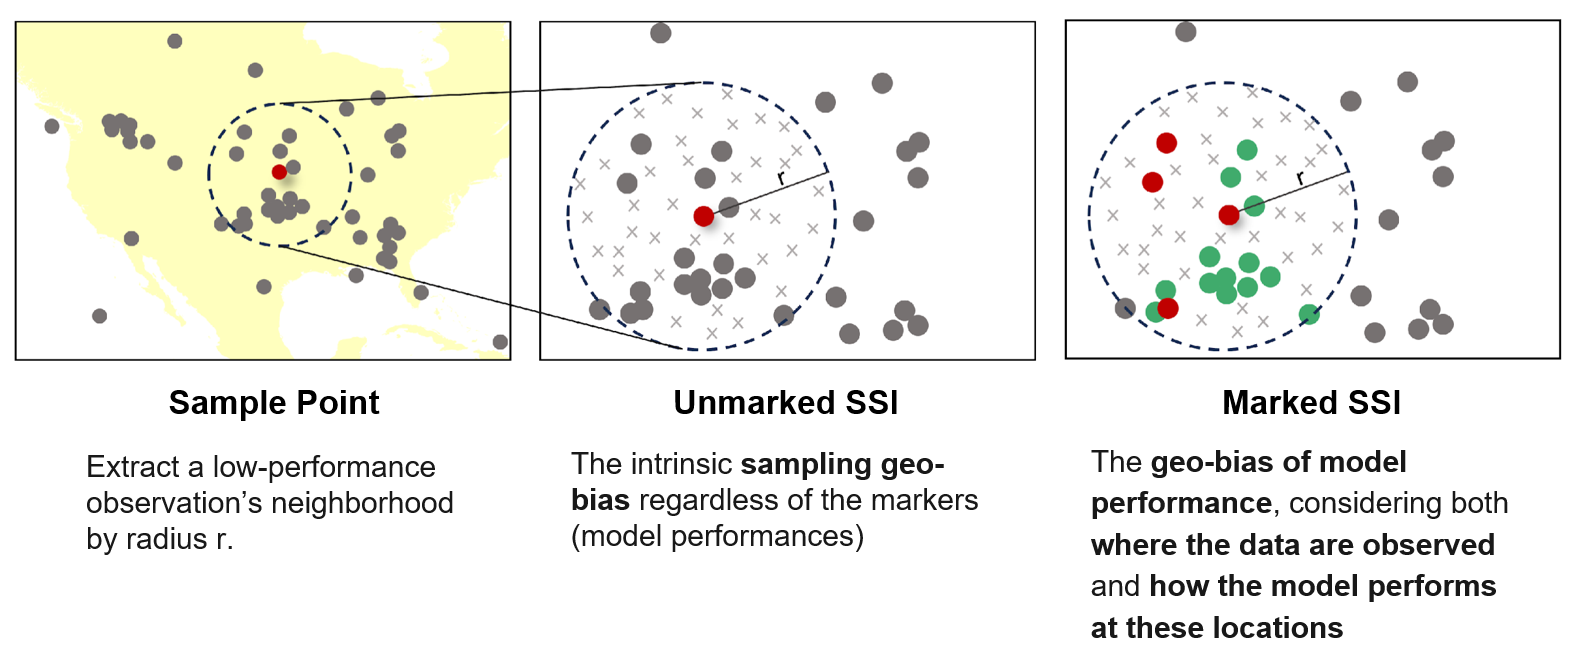

For more details regarding the geo-bias score, please refer to the following papers:

- Wu, Nemin, et al. *["TorchSpatial: A Location Encoding Framework and Benchmark for Spatial Representation Learning."](https://arxiv.org/abs/2406.15658)* arXiv preprint arXiv:2406.15658 (2024).
- Wang, Zhangyu, et al. *["Probing the Information Theoretical Roots of Spatial Dependence Measures."](https://arxiv.org/abs/2405.18459)* arXiv preprint arXiv:2405.18459 (2024).


In addition to classification performance, the results include **geo-bias scores** to evaluate how model performance varies geographically.

- **pnp_ssi**: Geo-bias score based on *unmarked* SSI (Spatial Statistical Independence).
- **rp_ssi**: Geo-bias score based on *marked* SSI.

These metrics help assess whether a model's predictions are geographically biased, and whether it generalizes well across different locations.

In [16]:
# example of geo-bias evaluation
import pandas as pd

input_file_path="../eval_results/eval_inat_2018__val_Sphere2Vec-sphereC+_ssi_0.05.csv"
df = pd.read_csv(input_file_path)
df.head()

,lat,lon,value,pnp_ssi,rp_ssi,weight
0,29.686216,-82.276573,1.0,334.953938,191.718402,100
1,29.042500,-95.419724,1.0,589.461784,589.461784,100
2,33.609531,-101.824638,1.0,419.521603,199.633985,100
3,23.299000,-106.443001,1.0,589.461784,577.387603,100
4,37.714001,-122.503830,0.0,589.461784,404.902421,100


In [9]:
# Visualization of Geo-Bias Score
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from matplotlib.colors import LinearSegmentedColormap


def create_fishnet(cell_size=1.0):
    """
    Create a fishnet (grid of polygons) that covers the whole world in PlateCarree projection.

    :param cell_size: Size of each grid cell in degrees (both latitude and longitude).
    :return: GeoDataFrame containing the grid polygons.
    """
    # Define the bounds for the whole world
    xmin, xmax, ymin, ymax = -180, 180, -90, 90

    # Create coordinates for the fishnet
    longitudes = np.arange(xmin, xmax, cell_size)
    latitudes = np.arange(ymin, ymax, cell_size)

    # Generate polygons for the grid
    polygons = []
    for lon in longitudes:
        for lat in latitudes:
            polygons.append(
                Polygon([
                    (lon, lat),
                    (lon + cell_size, lat),
                    (lon + cell_size, lat + cell_size),
                    (lon, lat + cell_size),
                    (lon, lat)
                ])
            )

    # Create a GeoDataFrame
    fishnet = gpd.GeoDataFrame({'geometry': polygons}, crs="EPSG:4326")
    return fishnet


def spatial_join_and_plot(input_file_path, cell_size=1.0, extent=[-180, 180, -90, 90], lon='lon1', lat='lat1', vmin = 0.0, vmax= 600, metric="hit@1", reverse = False, label_name='Accuracy', title=False):
    """
    Perform a spatial join to calculate the average value and pnp_ssi for points in each grid cell.

    :param input_file_path: Path to the CSV file containing 'lat', 'lon', and 'pnp_ssi' columns.
    :param cell_size: Size of each grid cell in degrees for the fishnet.
    """
    # Create the fishnet
    fishnet = create_fishnet(cell_size)

    # Load points from the CSV file
    data = pd.read_csv(input_file_path, low_memory=False).dropna(
        subset=[lon, lat])
    if reverse:
        data[metric] = 1- data[metric]
        
    gdf_points = gpd.GeoDataFrame(
        data, geometry=gpd.points_from_xy(data[lon], data[lat]), crs="EPSG:4326"
    )

    # Perform spatial join: Assign points to grid cells
    joined = gpd.sjoin(gdf_points, fishnet, how="inner")
    
    if metric in ["acc", "hit@1"]:
        averages = joined.groupby('index_right').agg(
            value=(metric, 'mean')
        ).reset_index()
    else:
        averages = joined.groupby('index_right').agg(
            value=(metric, 'mean')
        ).reset_index()

    # Merge averages back to the fishnet
    fishnet = fishnet.reset_index()
    fishnet = fishnet.merge(averages, left_on='index', right_on='index_right')

    # Create figure and axis
    fig = plt.figure(figsize=(12, 6))

    # Create main map axis with specific position
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.PlateCarree())
    # Set the extent to display the whole world
    ax.set_extent(extent, crs=ccrs.PlateCarree())


    cmap = plt.cm.get_cmap('Reds')
    cmap = LinearSegmentedColormap.from_list("adjusted_red", cmap(np.linspace(0.15, 1, 256)))

    fishnet['value'] = fishnet['value']/ (vmax - vmin)

    fishnet.plot(
        column='value',
        ax=ax,
        cmap=cmap,  # 'coolwarm',
        edgecolor=None,  # 'gray',
        linewidth=0.3,
        alpha=1.0,
        transform=ccrs.PlateCarree(),
        missing_kwds={"color": "lightgray"},
        vmin=0.0,
        vmax=1.0,
        legend=False  # Disable the default legend
    )

    ax.add_feature(cfeature.LAND, facecolor='lightgray')  # 设置大陆为浅灰色
    ax.set_axis_off()
    if title:
        ax.set_title(
            f"Fishnet with Average Value: {input_file_path}", fontsize=14)

    # bar
    cax = fig.add_axes([0.92, 0.2, 0.01, 0.6])
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
    sm.set_array([])

    cbar = plt.colorbar(sm, cax=cax)  
    cbar.set_label(label_name, fontsize=12, fontweight='bold',
                   rotation=-90, labelpad=15)
    cbar.set_ticks(np.linspace(0.0, 1.0, 5))

    plt.show()

/tmp/ipykernel_2571018/2875935015.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


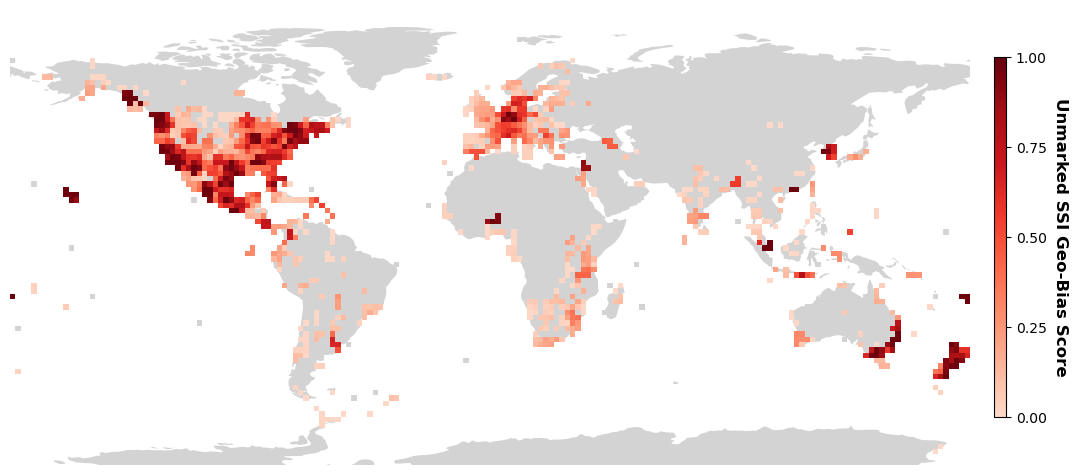

In [17]:
'''
Example visualization of the Unmarked SSI Geo-Bias Score for the Sphere2Vec-sphereC+ location encoder on the iNat2018 dataset.
'''

spatial_join_and_plot(input_file_path, cell_size=2,
                                    extent=[-180, 180, -80, 90], lon="lon", lat="lat", vmax=600, metric="pnp_ssi", label_name='Unmarked SSI Geo-Bias Score', title=False)